In [936]:
import numpy as np
from itertools import cycle
from random import uniform
import matplotlib.pyplot as plt
%matplotlib inline

## Sequence generator function

In [720]:
class SequenceGenerator:
    def __init__(self, x, sequence_size):
        if x.shape[0] < sequence_size:
            raise ValueError("sequence_size can't be bigger than total number of samples")
            
        self.sequence_size = sequence_size
        self.x = x
        self.samples_generated = 0
        self.epochs = 0
        self.samples_gen = self._samples_gen()
            
    def _samples_gen(self):        
        for i in cycle(range(self.x.shape[0] - self.sequence_size - 1)):
            sample_indices = range(i, i + self.sequence_size)
            targets_indices = range(i + 1, i + self.sequence_size + 1)
            batch = np.take(self.x, sample_indices).reshape(-1, 1)
            target = np.take(self.x, targets_indices).reshape(-1, 1)

            assert batch.shape == (self.sequence_size, 1)
            assert target.shape == (self.sequence_size, 1)

            yield batch, target
        
    def next_batch(self):
        batch, target = next(self.samples_gen)
        self.samples_generated += batch.shape[0]
        if self.samples_generated >= self.x.shape[0]:
            self.epochs += 1
            self.samples_generated = self.x.shape[0] - self.samples_generated
        return batch, target

## Initializers

In [721]:
class XavierInitializer:
    def do_init(self, tensor_shape):
        in_num, out_num = tensor_shape
        variance = np.sqrt(2.0 / (in_num + out_num))
        return np.random.normal(0, variance, size=tensor_shape)
    
class GaussianInitializer:
    def do_init(self, tensor_shape, m=0, sd=0.01):
        return np.random.normal(m, sd, tensor_shape)

## Optimizer

In [942]:
class SGD:
    def __init__(self, batch_size):
        self.batch_size = batch_size
    
    def update(self, lr, w, delta):
        w += -lr * delta / self.batch_size
        return w

## Weight serializer

In [723]:
class SerializedWeights:
    def __init__(self, rnn):
        if isinstance(rnn, RNN) == False:
            raise ValueError("rnn should be an instance of class RNN")
        self.sequence_size = rnn.sequence_size
        self._shift = {}
        self.units = rnn.units
        self.w = self._w(rnn)
    
    def _w(self, rnn):
        weights = []
        weights.extend(rnn.w_in.flatten())
        self._shift["w_in"] = ((0, len(weights)), rnn.w_in.shape)
        start = len(weights)
        
        weights.extend(rnn.w_rec.flatten())
        self._shift["w_rec"] = ((start, len(weights)), rnn.w_rec.shape)
        start = len(weights)
        
        weights.extend(rnn.w_out.flatten())
        self._shift["w_out"] = ((start, len(weights)), rnn.w_out.shape)
        start = len(weights)
        
        weights.extend(rnn.b_1.flatten())
        self._shift["b_1"] = ((start, len(weights)), rnn.b_1.shape)
        start = len(weights)
        
        weights.extend(rnn.b_2.flatten())
        self._shift["b_2"] = ((start, len(weights)), rnn.b_2.shape)  
        
        return weights
        
    def save_grads(self, dw_in, dw_rec, dw_out, db_1, db_2):
        grads = []
        grads.extend(dw_in.flatten())
        grads.extend(dw_rec.flatten())
        grads.extend(dw_out.flatten())
        grads.extend(db_1.flatten())
        grads.extend(db_2.flatten())
        self.g = grads
    
    def unpack(self):
        weights = []
        for idx, shape in self._shift.values():
            wts = np.take(self.w, range(idx[0], idx[1])).reshape(shape)
            weights.append(wts)
            
        return weights

## Simple Recurrent Neural Network

In [1103]:
class RNN:
    def __init__(self, units, sequence_size):
        self.units = units
        self.sequence_size = sequence_size
    
    #
    # Initialize weights
    #
    def _initialize_tensors(self):
        w_rec_shape = (self.units, self.units)
        w_in_shape = (self.units, 1)
        w_out_shape = (1, self.units)
        b_1_shape = (self.units, 1)
        b_2_shape = (1, 1)
        
        # Weights
        self.w_rec = np.identity(self.units)  # Fashion, fashion, fashion...
        self.w_in = self.initializer.do_init(w_in_shape)
        self.w_out = self.initializer.do_init(w_out_shape)
        self.b_1 = np.zeros(b_1_shape)
        self.b_2 = np.zeros(b_2_shape)
    
    #
    # Matrix to vector serialization 
    #
    def srn2vec(self, dw_in, dw_rec, dw_out, db_1, db_2):
        net = SerializedWeights(self)
        net.save_grads(dw_in, dw_rec, dw_out, db_1, db_2)
        return net
    
    #
    # Vector to matrix deserialization
    #
    def vec2srn(self, serialized_net):
        if isinstance(serialized_net, SerializedWeights) == False:
            raise ValueError("serialized_net should be an instance of class SerializedWeights")
            
        w_in, w_rec, w_out, b_1, b_2 = serialized_net.unpack()
        assert np.allclose(w_in, self.w_in)
        assert np.allclose(w_rec, self.w_rec)
        assert np.allclose(w_out, self.w_out)
        assert np.allclose(b_1, self.b_1)
        assert np.allclose(b_2, self.b_2)
        
        return w_in, w_rec, w_out, b_1, b_2
    
    #
    # Forward and backward propagation
    #
    def forward_backward(self, batch, target, initial_z, grad_clipping):
        in_state, z_state, y_hat_state, loss_state = {}, {}, {}, {}
        z_state[-1] = np.copy(initial_z)  # Inital state for z-1
        dz_next = np.zeros_like(initial_z)  # Inital state for dz+1
        dw_in = np.zeros_like(self.w_in)
        dw_rec = np.zeros_like(self.w_rec)
        dw_out = np.zeros_like(self.w_out)
        db_1 = np.zeros_like(self.b_1)
        db_2 = np.zeros_like(self.b_2)
        loss = 0

        # Forward prop
        for i in range(batch.shape[0]):
            # Pass through the first function
            in_state[i] = batch[i, :].reshape(1, -1)
            z_state[i] = np.tanh(self.w_in @ in_state[i] + self.w_rec @ z_state[i-1] + self.b_1)
            assert z_state[i].shape == (self.units, batch.shape[-1])

            # Pass through the second function
            y_hat_state[i] = np.tanh(self.w_out @ z_state[i] + self.b_2)
            assert y_hat_state[i].shape == (1, batch.shape[-1])

            # Pass through the loss function
            loss_state[i] = 0.5 * (y_hat_state[i] - target[i])**2
            assert loss_state[i].shape == (1, batch.shape[-1])

            loss += np.mean(loss_state[i])

        # Backward prop
        for i in reversed(range(batch.shape[0])):
            # Pass back through the loss function
            dy_hat = y_hat_state[i] - target[i]
            assert dy_hat.shape == (1, batch.shape[-1])

            # Pass back through the second function
            da_2 = (1 - y_hat_state[i] * y_hat_state[i]) * dy_hat
            dw_out += da_2 @ z_state[i].T
            db_2 += np.sum(da_2, axis=1).reshape(-1, 1)
            assert dw_out.shape == self.w_out.shape
            assert db_2.shape == self.b_2.shape

            # Pass back through the first function
            dz = self.w_out.T @ da_2 + dz_next
            da_1 = (1 - z_state[i] * z_state[i]) * dz
            dw_rec += da_1 @ z_state[i-1].T
            dw_in += da_1 @ in_state[i].T
            db_1 += np.sum(da_1, axis=1).reshape(-1, 1)
            dz_next = self.w_rec.T @ da_1
            assert dw_rec.shape == self.w_rec.shape
            assert dw_in.shape == self.w_in.shape
            assert db_1.shape == self.b_1.shape

        # Gradient clipping
        if grad_clipping:
            for delta in (dw_in, dw_rec, dw_out, db_1, db_2):
                np.clip(delta, -1, 1, out=delta)

        return loss, dw_in, dw_rec, dw_out, db_1, db_2, z_state[batch.shape[0] - 1]
    
    #
    # Fit model to the data
    #
    def fit(self, x, learning_rate, epochs=10, grad_clipping=False):
        self.batch_generator = SequenceGenerator(x, self.sequence_size)
        self.initializer = XavierInitializer()
        # self.initializer = GaussianInitializer()
        self.opt = SGD(self.sequence_size)
        self._initialize_tensors()
        z_init = np.zeros((self.units, 1))
        current_epoch = 1
        current_iter = 1
        epoch_loss = []
        total_loss = []
        
        # Start training 
        while self.batch_generator.epochs < epochs:
            batch, target = self.batch_generator.next_batch()

            # Run forward, backward and return loss
            loss, dw_in, dw_rec, dw_out, db_1, db_2, z_init = self.forward_backward(
                batch, 
                target, 
                z_init, 
                grad_clipping
            )

            net_state = self.srn2vec(dw_in, dw_rec, dw_out, db_1, db_2)
#             w_in, w_rec, w_out, b_1, b_2 = self.vec2srn(net_state)
            
            # Learning rate decay schedule
            lr = learning_rate / np.sqrt(current_iter + 1)
            
            # Weight update
            params = zip((self.w_in, self.w_rec, self.w_out, self.b_1, self.b_2),
                         (dw_in, dw_rec, dw_out, db_1, db_2))
            
            for wts, grads in params:
                self.opt.update(lr, wts, grads)

            # Report progress
            epoch_loss.append(loss)
            
            if self.batch_generator.epochs >= current_epoch:
                avg_loss = np.mean(epoch_loss)
                print("Epoch {}, loss: {:.6f}, weights norm: {:.2f}, gradients norm {:.2f}".\
                      format(current_epoch, 
                             avg_loss,
                             np.linalg.norm(net_state.w),
                             np.linalg.norm(net_state.g))
                     )

                z_init = np.zeros_like(z_init)
                epoch_loss = []
                total_loss.append(avg_loss)
                current_epoch += 1
            
            current_iter += 1
        
        return total_loss
    
    #        
    # Numerical vs Analytic gradient check
    #
    def gradient_check(self):
        batch, target = SequenceGenerator(x, self.sequence_size).next_batch()
        self.initializer = XavierInitializer()
        self._initialize_tensors()
        initial_z = np.zeros((self.units, 1))
        
        num_checks = 10
        eps = 1e-5
        
        _, dw_in, dw_rec, dw_out, db_1, db_2, _ = self.forward_backward(
            batch, 
            target, 
            initial_z, 
            grad_clipping=False
        )
        
        params = zip(
            (self.w_in, self.w_rec, self.w_out, self.b_1, self.b_2),
            (dw_in, dw_rec, dw_out, db_1, db_2),
            ("dw_in", "dw_rec", "dw_out", "db_1", "db_2")
        )
        
        for wts, delta, name in params:
            assert wts.shape == delta.shape
            print("\nComparing {} randomly taken values for {}:".format(num_checks, name))
            
            for _ in range(num_checks):
                rand_idx = int(uniform(0, wts.size))
                w = wts.flat[rand_idx]
                
                wts.flat[rand_idx] = w + eps
                f0, _, _, _, _, _, _ = self.forward_backward(
                    batch, 
                    target, 
                    initial_z, 
                    grad_clipping=False
                )
                
                wts.flat[rand_idx] = w - eps
                f1, _, _, _, _, _, _ = self.forward_backward(
                    batch, 
                    target, 
                    initial_z, 
                    grad_clipping=False
                )
                wts.flat[rand_idx] = w
                
                numerical = (f0 - f1) / (2 * eps)
                analytic = delta.flat[rand_idx]
                error = abs(analytic - numerical) / abs(numerical + analytic)
                
                print("Relative error: {:.1E}, numerical: {:.4f}, analytic: {:.4f}".
                    format(error, numerical, analytic))

## Read dataset

In [1104]:
with open('MackeyGlass.csv') as f:
    x = np.array([float(n) for n in f.readline().split(';')]).reshape(-1, 1)

## Numerical vs Analytic gradient check

In [1105]:
net = RNN(units=16, sequence_size=5)
net.gradient_check()


Comparing 10 randomly taken values for dw_in:
Relative error: 9.0E-11, numerical: 0.4602, analytic: 0.4602
Relative error: 3.1E-11, numerical: 0.0261, analytic: 0.0261
Relative error: 4.2E-11, numerical: -0.2354, analytic: -0.2354
Relative error: 9.9E-12, numerical: -0.0605, analytic: -0.0605
Relative error: 6.3E-11, numerical: 0.6280, analytic: 0.6280
Relative error: 4.0E-11, numerical: -0.1812, analytic: -0.1812
Relative error: 3.2E-11, numerical: -0.2817, analytic: -0.2817
Relative error: 9.0E-11, numerical: 0.4602, analytic: 0.4602
Relative error: 4.2E-11, numerical: -0.5609, analytic: -0.5609
Relative error: 6.2E-11, numerical: 0.6280, analytic: 0.6280

Comparing 10 randomly taken values for dw_rec:
Relative error: 3.0E-11, numerical: -0.0085, analytic: -0.0085
Relative error: 1.1E-11, numerical: -0.1807, analytic: -0.1807
Relative error: 8.6E-12, numerical: -0.0577, analytic: -0.0577
Relative error: 5.8E-11, numerical: -0.1358, analytic: -0.1358
Relative error: 1.8E-11, numerica

## Fit model

In [1119]:
net = RNN(units=128, sequence_size=1)
progress = net.fit(x, learning_rate=5e-2, epochs = 25, grad_clipping=False)

Epoch 1, loss: 0.031879, weights norm: 11.48, gradients norm 1.00
Epoch 2, loss: 0.020059, weights norm: 11.48, gradients norm 0.93
Epoch 3, loss: 0.014394, weights norm: 11.48, gradients norm 0.67
Epoch 4, loss: 0.011931, weights norm: 11.48, gradients norm 0.06
Epoch 5, loss: 0.010387, weights norm: 11.48, gradients norm 0.83
Epoch 6, loss: 0.009306, weights norm: 11.48, gradients norm 1.54
Epoch 7, loss: 0.008489, weights norm: 11.48, gradients norm 1.66
Epoch 8, loss: 0.007794, weights norm: 11.48, gradients norm 1.18
Epoch 9, loss: 0.007172, weights norm: 11.48, gradients norm 0.60
Epoch 10, loss: 0.006623, weights norm: 11.48, gradients norm 0.23
Epoch 11, loss: 0.006150, weights norm: 11.48, gradients norm 0.00
Epoch 12, loss: 0.005752, weights norm: 11.48, gradients norm 0.16
Epoch 13, loss: 0.005425, weights norm: 11.48, gradients norm 0.24
Epoch 14, loss: 0.005162, weights norm: 11.48, gradients norm 0.20
Epoch 15, loss: 0.004959, weights norm: 11.48, gradients norm 0.03
Epoc

## Plot learning curve

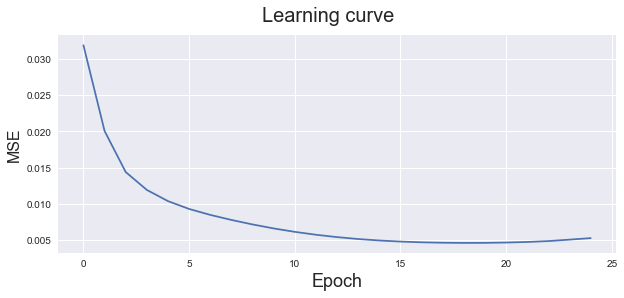

In [1120]:
fig = plt.figure(figsize=(10, 4))
plt.plot(progress)
fig.suptitle('Learning curve', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('MSE', fontsize=16)
plt.show()